In [8]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)

from models import DeepConditionalModel
from inn_utils import train_online_ml, compute_metrics
from process_models import simulate_sir, plot_sir
from viz import plot_true_est_scatter, plot_true_est_posterior, plot_losses, plot_sbc, plot_metrics, plot_variance

In [2]:
import matplotlib.pyplot as plt

In [3]:
tf.enable_eager_execution()

In [4]:
%load_ext autoreload
%autoreload 2

# Summary network for the SIR model
<p>We use a 1D ConvNet for the stochastic SIR model</p>

In [5]:
class ConvNet1D(tf.keras.Model):
    
    def __init__(self):
        super(ConvNet1D, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Conv1D(64, kernel_size=5, strides=3, activation='relu'),
            tf.keras.layers.Conv1D(64, kernel_size=5, strides=3, activation='relu'),
            tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, activation='relu'),
            tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, activation='relu'),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(64, kernel_initializer='glorot_uniform', activation='elu'),
            
        ])
        
    def call(self, x, training=True):
        x = self.summary_part(x, training=training)
        return x

# Initialization 

In [33]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
param_names = [r'$\beta$', r'$\gamma$']
theta_dim = 2
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 128
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 5
n_test = 300
n_test2 = 3
n_samples_posterior = 1000
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

## Create a test set

In [29]:
X_test, theta_test = simulate_sir(n_test, n_points=500)

In [13]:
# For full posteriors
X_test2, theta_test2 = simulate_sir(n_test2, n_points=500)

In [ ]:
# For SBC
X_sbc, theta_sbc = simulate_sir(5000, n_points=500)

In [34]:
summary_net = ConvNet1D()
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Checkpoint manager

In [35]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/sir', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


## Plot SIR

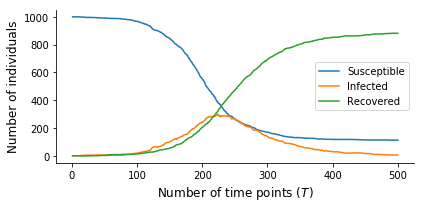

In [22]:
plot_sir(0.5, 0.2, n_points=500, figsize=(6, 3), N=1000, filename='SIR')

## Plot performance of untrained model

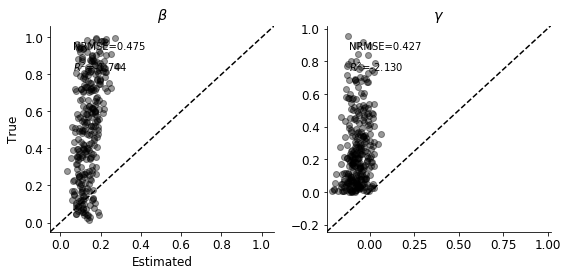

In [32]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(8, 4))

# Train the model

In [ ]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online_ml(model, optimizer, simulate_sir, iterations_per_epoch, 
                            batch_size, p_bar, clip_value=clip_value, 
                            global_step=global_step)
        
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(8, 4))
        theta_samples = np.concatenate([model.sample(x, n_samples=250, to_numpy=True)
                                        for x in tf.split(X_sbc, 20, 0)], axis=0)
        plot_sbc(theta_samples, theta_sbc, param_names, figsize=(8, 4), bins=25)
        
        # Save model
        manager.save()

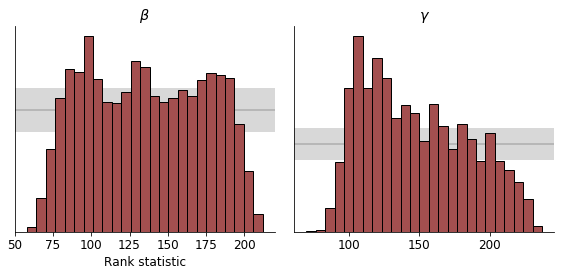

# Evaluate the trained model

## Posterior means (recovery)

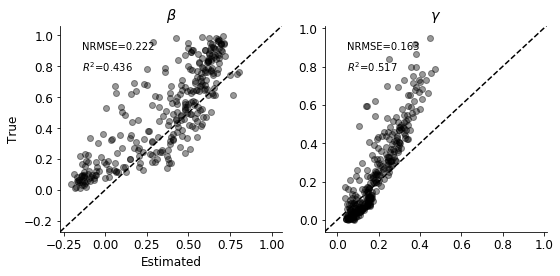

In [27]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, 
                      param_names, figsize=(8, 4))

## Full posteriors

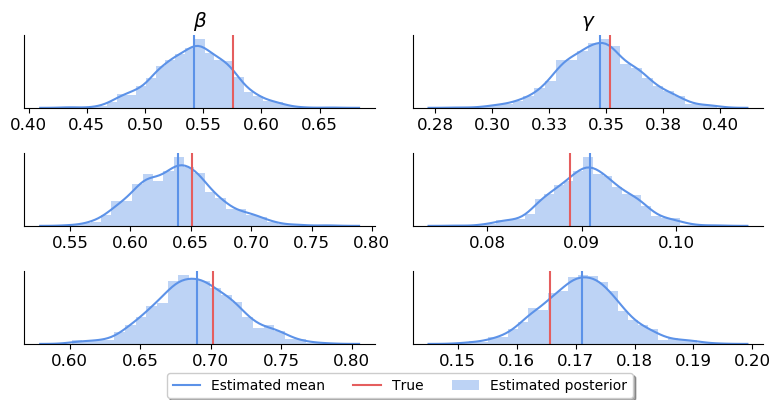

In [158]:
plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test2, theta_test=theta_test2, tight=True, figsize=(8, 4), filename='SIR')

In [11]:
# Make sure GPU memory does not blow off
theta_samples = np.concatenate([model.sample(x, n_samples=250, to_numpy=True)
                                for x in tf.split(X_sbc, 20, 0)], axis=0)
plot_sbc(theta_samples, theta_sbc, param_names, figsize=(8, 4), bins=25)

Instructions for updating:
Colocations handled automatically by placer.


## Compute metrics for all T

In [146]:
n_min=200
n_max=500
with tqdm(total=n_max-n_min, desc='Computation of metrics') as p_bar:
    ns, metrics = compute_metrics(model, param_names, simulate_sir, n_test, 
                                  n_samples_posterior, p_bar=p_bar,
                                  n_min=n_min, n_max=n_max)

### Plot metrics

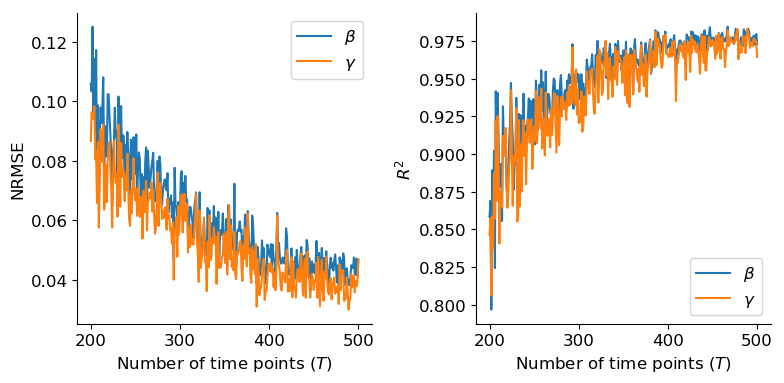

In [153]:
plot_metrics(metrics, ns, param_names, figsize=(8, 4), 
             xlabel=r'Number of time points ($T$)', filename='SIR')

### Plot variances

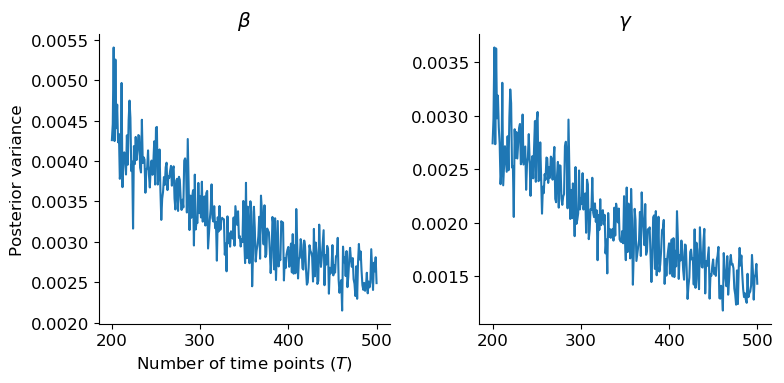

In [156]:
plot_variance(metrics['var'], ns, param_names, figsize=(8, 4), 
              xlabel=r'Number of time points ($T$)', filename='SIR')

## Speed of inference

In [16]:
# For full posteriors
n_speed = 1000
X_test3, theta_test3 = simulate_sir(n_speed, n_points=500)

In [19]:
%timeit model.sample(X_test3, n_samples_posterior)

1.1 s ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
